# Hypothesis:
- Control algorithms based on RL could work better for different (even huge enough) `dt`'s than PID controller.

## Imports and utility functions

In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
from tqdm import tqdm
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter("ignore")
from robot_model import *
torch.manual_seed(42)
np.random.seed(42)

from stable_baselines3 import PPO, DDPG, TD3, SAC
from sb3_contrib import TRPO
from robot_model import CDPR4_env, CDPR4

device = torch.device("cpu")

In [2]:
def plot_states(sol, t_span):
    plt.figure(figsize=(10, 6))
    plt.plot(t_span, sol[:,0], label='x')
    plt.plot(t_span, sol[:,1], label='y')
    plt.plot(t_span, sol[:,2], label='z')
    # plt.plot(t_span, sol[:,3], label='dx')
    # plt.plot(t_span, sol[:,4], label='dy')
    # plt.plot(t_span, sol[:,5], label='dz')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title('System')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_position_error(actual_x, desired_x, t_span):
    if desired_x.shape[0] == 3:
        err = np.array([desired_x - actual_x[i, :3] for i in range(actual_x.shape[0])])
        plt.figure(figsize=(10, 6))
        plt.plot(t_span, err[:,0], label='x err')
        plt.plot(t_span, err[:,1], label='y err')
        plt.plot(t_span, err[:,2], label='z err')
        plt.plot(t_span, [np.linalg.norm(i) for i in err], label='abs err')
        plt.xlabel('Time')
        plt.ylabel('State Variables')
        plt.title('Position Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        err = np.array([desired_x[i, :3] - actual_x[i, :3] for i in range(actual_x.shape[0])])
        plt.figure(figsize=(10, 6))
        plt.plot(t_span, err[:,0], label='x err')
        plt.plot(t_span, err[:,1], label='y err')
        plt.plot(t_span, err[:,2], label='z err')
        plt.plot(t_span, [np.linalg.norm(i) for i in err], label='abs err')
        plt.xlabel('Time')
        plt.ylabel('State Variables')
        plt.title('Position Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    
def get_rms_err(actual_x, desired_x, t_span):
    abs_err = np.array([np.linalg.norm(desired_x - actual_x[i, :3]) for i in range(actual_x.shape[0])]) 
    mean_err = np.mean(abs_err**2)
    return np.sqrt(mean_err)

def plot_error(errors, title='Error Over Time', xlabel='Time Steps', ylabel='Error'):
    """
    Plot the error over time.
    
    Parameters:
    errors (np.array): Array of errors with shape (n,)
    title (str): Title of the plot
    xlabel (str): Label for the x-axis
    ylabel (str): Label for the y-axis
    """
    
    # Ensure errors is a numpy array
    errors = np.array(errors)
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot the errors
    plt.plot(errors, color='blue', linewidth=2, label='Error')
    
    # Set titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add grid for better readability
    plt.grid(True)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [3]:
max_force = 15
action_decoder = {
            i: np.array([int(b) for b in f'{i:04b}']) for i in range(16)
        }

def system(model, X, t_span, robot_model):
    global dt
    
    obs = np.copy(X)
    states = np.zeros((t_span.shape[0], 6))
    states[0, :] = X[:6]
    step_count = 1  # Initialize step counter
    done = False
    
    # go to position
    while not done and step_count < t_span.shape[0]:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = robot_model.step(action)
        states[step_count, :] = obs[:6]
        step_count += 1

    if step_count< t_span.shape[0]:
        obs = np.hstack((states[step_count, :], X[3:6]))
    else:
        return states, done

    # try to hold the position
    while step_count<t_span.shape[0]:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = robot_model.step(action)
        states[step_count, :] = obs[:6]
        step_count += 1

    return states, done

In [4]:
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def horizontal_circle_trajectory_points(t_span, h=1.0):
    """
    Horizontal circle trajectory: R=0.5m, on heigth h=1m
    
    Parameters:
    t_span: np.array
    h: float
    """
    R=0.5
    h=1.0
    n = t_span.shape[0] # n points in trajectory
    phi = np.linspace(0, 2*np.pi, n)
    
    trajectory = np.zeros((n, 3))
    trajectory[:, 0] = R*np.cos(phi) # X
    trajectory[:, 1] = R*np.sin(phi) # Y
    trajectory[:, 2] = h # Z
        
    return trajectory

def horizontal_spiral_trajectory_points(t_span, h=1.0):
    """
    Horizontal spiral (mirrored archimedes) trajectory: R=0.15m, on heigth h=1m
    
    Parameters:
    t_span: np.array
    h: float
    """
    R=0.15
    h=1.0
    n = t_span.shape[0] # n points in trajectory
    phi = np.linspace(0, 2*np.pi, n)
    
    trajectory = np.zeros((3*n, 3))
    trajectory[:n, 0] = R*phi*np.cos(phi) # X
    trajectory[:n, 1] = R*phi*np.sin(phi) # Y
    
    trajectory[n:2*n, 0] = R*phi[-1]*np.cos(phi) # X
    trajectory[n:2*n, 1] = R*phi[-1]*np.sin(phi) # Y
    
    trajectory[2*n:3*n, 0] = R*phi[::-1]*np.cos(phi) # X
    trajectory[2*n:3*n, 1] = R*phi[::-1]*np.sin(phi) # Y
    
    trajectory[:, 2] = h # Z
        
    return trajectory[::3]

def horizontal_spiral2_trajectory_points(t_span, h=1.0):
    """
    Horizontal spiral trajectory: R=0.15m, on heigth h=1m
    
    Parameters:
    t_span: np.array
    h: float
    """
    R=0.45
    a = 0.35
    h=1.0
    n = t_span.shape[0] # n points in trajectory
    phi = np.linspace(0, 2*np.pi, n)
    trajectory = np.zeros((3*n, 3))
    
    trajectory[:n, 1] = (a + R*np.cos(phi))*np.cos(phi) # Y
    trajectory[:n, 0] = (a + R*np.cos(phi))*np.sin(phi) # X
    
    trajectory[n:2*n, 1] = (a + R)*np.cos(phi) # Y
    trajectory[n:2*n, 0] = (a + R)*np.sin(phi) # X
    
    trajectory[2*n:3*n, 1] = (a + R*np.cos(phi[::-1]))*np.cos(phi) # Y
    trajectory[2*n:3*n, 0] = (a + R*np.cos(phi[::-1]))*np.sin(phi) # X
    
    trajectory[:, 2] = h # Z
        
    return trajectory[::3]

def plot_trajectory_3d(points):
    """
    Plot a 3D trajectory given an array of points.
    
    Parameters:
    points (np.array): Array of shape (n, 3) containing x, y, z coordinates.
    """
    # Ensure the input is a numpy array
    points = np.array(points)
    
    # Check if the shape is correct
    if points.shape[1] != 3:
        raise ValueError("Input array must have shape (n, 3)")
    
    # Extract x, y, z coordinates
    x, y, z = points.T
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory
    ax.plot(x, y, z, label='Trajectory')
    
    # Plot start and end points
    ax.scatter(x[0], y[0], z[0], color='green', s=100, label='Start')
    ax.scatter(x[-1], y[-1], z[-1], color='red', s=100, label='End')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Trajectory')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()

def follow_trajectory(model, initial_state, trajectory, robot_model, max_steps=32, dt=0.1):
    """
    Function for a robot to follow a given trajectory using an RL model.

    Parameters:
    model: The RL model used for prediction
    initial_state: Initial state of the robot (numpy array)
    trajectory: Array of points to follow (shape: n x 3)
    robot_model: The robot model object
    max_steps: Maximum number of steps to simulate
    dt: Time step for simulation

    Returns:
    states: Array of robot states throughout the simulation
    reached_points: List of indices of reached trajectory points
    """
    X = initial_state.copy()
    states = []
    states.append(X[:3].copy())
    reached_points = []
    abs_err = [0.0]  # initial point is the first trajectory point
    robot_model.cur_state = X

    # Iterate through trajectory points using tqdm
    for target_idx in tqdm(range(1, len(trajectory))):
        done = False
        step_count = 0
        while not done and step_count < max_steps:
            action, _states = model.predict(X, deterministic=True)
            X, reward, done, truncated, info = robot_model.step(action)
            states.append(X[:3].copy())
            step_count += 1

        abs_err.append(euclidean(X[:3], trajectory[target_idx]))

        # Update next target point
        if target_idx + 1 < len(trajectory):
            X[6:9] = trajectory[target_idx + 1]

    # print(f"Reached {len(reached_points)} points")
    return np.array(states), reached_points, np.array(abs_err)

def visualize_simulation(trajectory, robot_states, reached_points, interval=100, save_animation=False, gif_name='base_model'):
    """
    Visualize the simulation of the robot following a trajectory.
    
    Parameters:
    trajectory: Array of target points (shape: n x 3)
    robot_states: Array of robot states throughout the simulation (shape: m x 6)
    reached_points: List of indices of reached trajectory points
    interval: Interval between frames in milliseconds
    save_animation: Boolean, whether to save the animation as a gif
    """
    
    # Extract robot positions from states
    robot_positions = robot_states[:, :3]
    if robot_positions.ndim == 3:
        robot_positions = robot_positions.reshape(-1, 3)
    
    # Create the figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the target trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b--', label='Target Trajectory')
    
    # Plot start and end points of the target trajectory
    ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], color='green', s=100, label='Start')
    ax.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2], color='red', s=100, label='End')
    
    # Initialize the robot position plot
    robot_plot, = ax.plot([], [], [], 'ro-', label='Robot Path', markersize=8)
    current_pos, = ax.plot([], [], [], 'ko', markersize=10, label='Current Position')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Robot Trajectory Simulation')
    ax.legend()
    
    # Set axis limits
    ax.set_xlim([min(trajectory[:, 0].min(), robot_positions[:, 0].min()) - 1,
                 max(trajectory[:, 0].max(), robot_positions[:, 0].max()) + 1])
    ax.set_ylim([min(trajectory[:, 1].min(), robot_positions[:, 1].min()) - 1,
                 max(trajectory[:, 1].max(), robot_positions[:, 1].max()) + 1])
    ax.set_zlim([min(trajectory[:, 2].min(), robot_positions[:, 2].min()) - 1,
                 max(trajectory[:, 2].max(), robot_positions[:, 2].max()) + 1])
    
    # Animation update function
    def update(frame):
        robot_plot.set_data(robot_positions[:frame, 0], robot_positions[:frame, 1])
        robot_plot.set_3d_properties(robot_positions[:frame, 2])
        current_pos.set_data([robot_positions[frame, 0]], [robot_positions[frame, 1]])
        current_pos.set_3d_properties([robot_positions[frame, 2]])
        
        # Highlight reached points
        for point in reached_points:
            if frame >= point:
                ax.scatter(trajectory[point, 0], trajectory[point, 1], trajectory[point, 2], 
                           color='green', s=100, alpha=0.5)
        
        return robot_plot, current_pos
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(robot_positions), interval=interval, blit=True)
    
    if save_animation:
        anim.save(f'visualizations/robot_trajectory_simulation_{gif_name}.gif', writer='pillow')
    
    plt.show()

## DDPG, PPO and TRPO on different `dt`'s

all models were learned on `dt=0.1` sec

In [5]:
# first check of hypothesis
robot_model_trpo = CDPR4_env(pos=np.array([.0, .0, 1.]), is_continuous=True)
modelSB3_TRPO = TRPO.load("models/trpo_cdpr4_model.zip", env=robot_model_trpo, custom_objects={'observation_space': robot_model_trpo.observation_space, 'action_space': robot_model_trpo.action_space}, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: macOS-15.2-arm64-arm-64bit Darwin Kernel Version 24.2.0: Fri Dec  6 19:01:59 PST 2024; root:xnu-11215.61.5~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.0-125-generic-x86_64-with-glibc2.35 # 135-Ubuntu SMP Fri Sep 27 13:53:58 UTC 2024
- Python: 3.10.12
- Stable-Baselines3: 2.4.0
- PyTorch: 2.4.0+cu124
- GPU Enabled: True
- Numpy: 1.26.1
- Cloudpickle: 3.0.0
- Gymnasium: 1.0.0



In [6]:
robot_model_trpo.dt

0.1

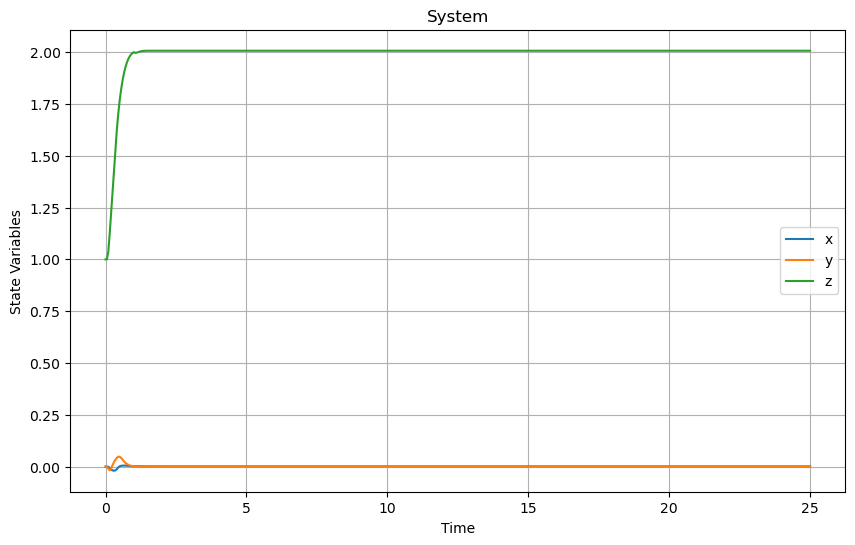

In [7]:
# change dt to 0.05
robot_model_trpo.dt = 0.05
eps = 500
t_span = np.linspace(0, robot_model_trpo.dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)
des_pos = np.array([0,0,2], dtype=np.float32)
X = np.hstack([X, des_pos])
robot_model_trpo.cur_state = X

sol_trpo, d = system(modelSB3_TRPO, X, t_span, robot_model_trpo)
plot_states(sol_trpo, t_span)

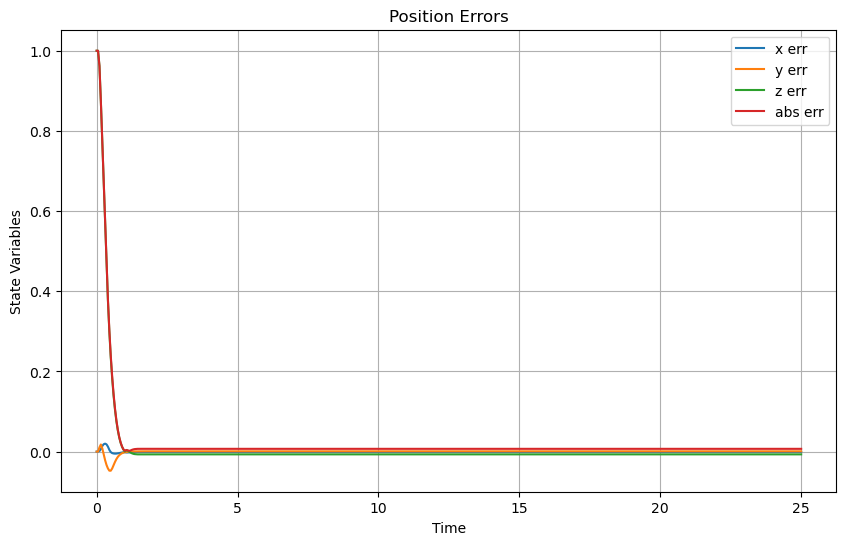

In [8]:
plot_position_error(sol_trpo, des_pos, t_span)

### Circle trajectory

In [9]:
# circle trajectory of 20 points
traj1 = horizontal_circle_trajectory_points(t_span = np.linspace(0, 10, 20)) 

robot_model_trpo.cur_state = np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1]))

states, reached_p, error = follow_trajectory(model=modelSB3_TRPO, 
                  initial_state=np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1])), 
                  trajectory=traj1, 
                  robot_model=robot_model_trpo)

100%|██████████| 19/19 [00:00<00:00, 403.33it/s]


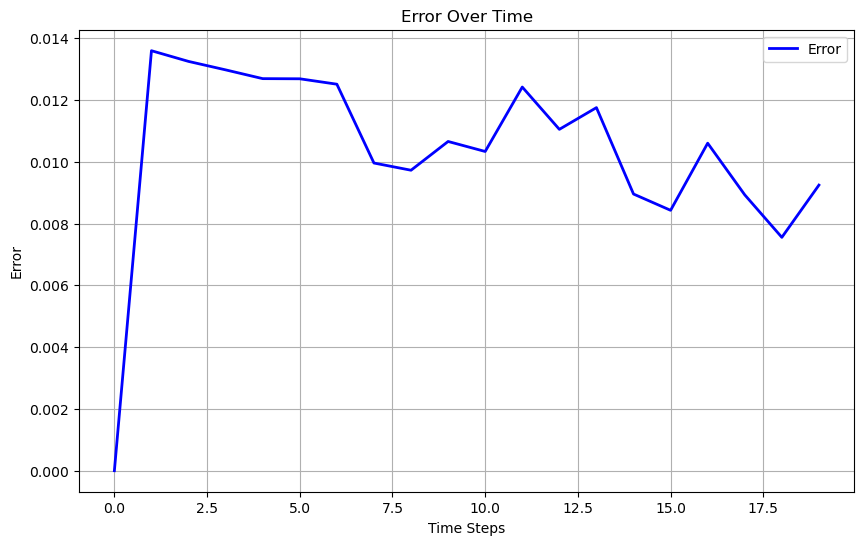

In [10]:
plot_error(error)

In [11]:
# RMS Error
mean_err = np.mean(error**2)
np.sqrt(mean_err)

0.010772970146075948

### Collecting data for different `dt`

dt array = [0.2, 0.15, 0.1, 0.05, 0.025, 1/60, 0.01, 1/400]

In [12]:
dt_arr = [0.2, 0.15, 0.1, 0.05, 0.025, 1/60, 0.01, 1/400]

# models loading
robot_model_td3 = CDPR4_env(pos=np.array([.0, .0, 1.]), is_continuous=True)
modelSB3_TD3 = TD3.load("models/mi93o31c/ddpg_cdpr4_model.zip", env=robot_model_td3, custom_objects={'observation_space': robot_model_td3.observation_space, 'action_space': robot_model_td3.action_space}, print_system_info=True)

robot_model_ppo = CDPR4_env(pos=np.array([.0, .0, 1.]), is_continuous=False)
robot_model_ppo.num_discretized_actions = robot_model_ppo.num_discretized_actions[0]
modelSB3_PPO = PPO.load("models/ppo_cdpr4_model_3m_timesteps.zip", env=robot_model_ppo, custom_objects={'observation_space': robot_model_ppo.observation_space, 'action_space': robot_model_ppo.action_space}, print_system_info=True)

robot_model_trpo = CDPR4_env(pos=np.array([.0, .0, 1.]), is_continuous=True)
modelSB3_TRPO = TRPO.load("models/trpo_cdpr4_model.zip", env=robot_model_trpo, custom_objects={'observation_space': robot_model_trpo.observation_space, 'action_space': robot_model_trpo.action_space}, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: macOS-15.2-arm64-arm-64bit Darwin Kernel Version 24.2.0: Fri Dec  6 19:01:59 PST 2024; root:xnu-11215.61.5~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED MODEL SYSTEM INFO ==
- OS: macOS-15.1.1-arm64-arm-64bit Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== CURRENT SYSTEM INFO ==
- OS: macOS-15.2-arm64-arm-64bit Darwin Kernel Version 24.2.0: Fri Dec  6 19:01:59 PST 2024; root:xnu-11215.61.5~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED M

In [13]:
def rms_errors_different_dt(robot_model, control_agent, trajectory, dt_arr):
    rms_errors_dict = {}
    
    for dt in dt_arr:
        # initialization
        robot_model.dt = dt
        robot_model.cur_state = np.hstack((trajectory[0], 
                                   np.zeros(3),
                                   trajectory[1]))
        
        states, reached_p, error = follow_trajectory(model=control_agent, 
                  initial_state=np.hstack((trajectory[0], 
                                   np.zeros(3),
                                   trajectory[1])), 
                  trajectory=trajectory, 
                  robot_model=robot_model)
        
        mean_err = np.mean(error**2)
        rms_errors_dict[dt] = np.sqrt(mean_err)
    
    return rms_errors_dict.copy()

In [14]:
# circle trajectory of 20 points
circle_trajectory = horizontal_circle_trajectory_points(t_span = np.linspace(0, 10, 20)) 
# spiral 1 trajectory of 60 points
spiral1 = horizontal_spiral_trajectory_points(t_span = np.linspace(0, 10, 60)) 
# spiral 2 trajectory of 60 points
spiral2 = horizontal_spiral2_trajectory_points(t_span = np.linspace(0, 10, 60)) 

rms_errors_DDPG_circle = rms_errors_different_dt(robot_model_td3,
                                          modelSB3_TD3,
                                          circle_trajectory,
                                          dt_arr)

rms_errors_PPO_circle = rms_errors_different_dt(robot_model_ppo,
                                          modelSB3_PPO,
                                          circle_trajectory,
                                          dt_arr)

rms_errors_TRPO_circle = rms_errors_different_dt(robot_model_trpo,
                                          modelSB3_TRPO,
                                          circle_trajectory,
                                          dt_arr)

100%|██████████| 19/19 [00:00<00:00, 171.62it/s]


In [15]:
def plot_rms_vs_dt(data):
    """
    Plots the dependency of RMS error on dt.

    Parameters:
    data (dict): A dictionary where keys are dt values and values are RMS errors.
    """
    # Extract dt (keys) and RMS error (values)
    dt = list(data.keys())
    rms_error = list(data.values())

    # Sort the data by dt
    sorted_dt, sorted_rms_error = zip(*sorted(zip(dt, rms_error)))

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_dt, sorted_rms_error, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel('dt')
    plt.ylabel('RMS Error')
    plt.title('Dependency of RMS Error on dt')
    plt.grid(True)

    # Show the plot
    plt.show()

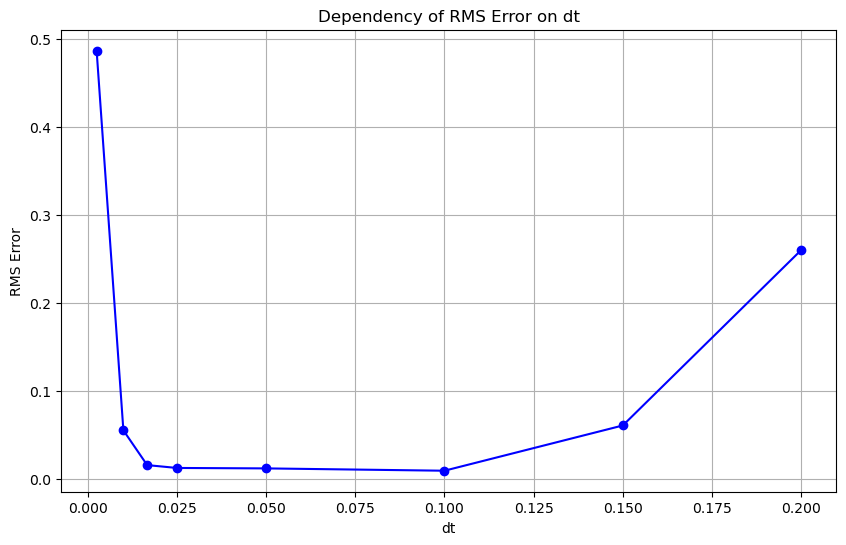

In [16]:
plot_rms_vs_dt(rms_errors_DDPG_circle)

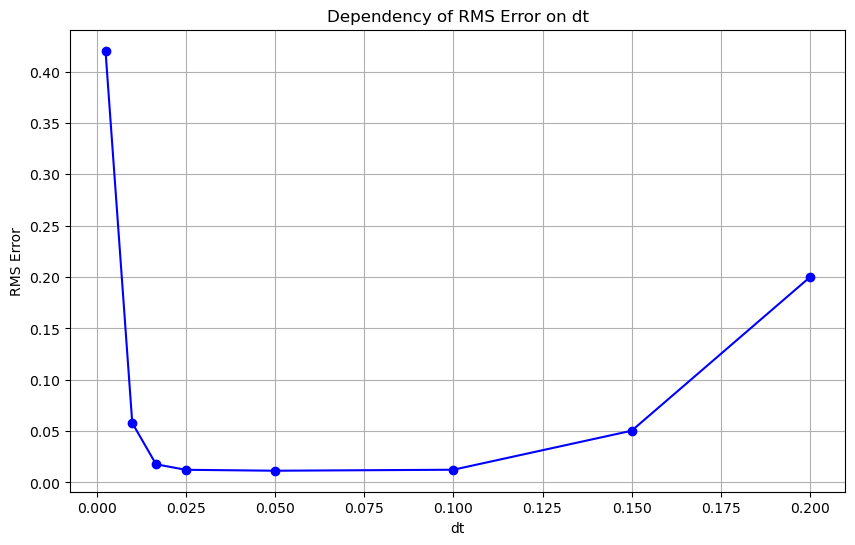

In [17]:
plot_rms_vs_dt(rms_errors_PPO_circle)

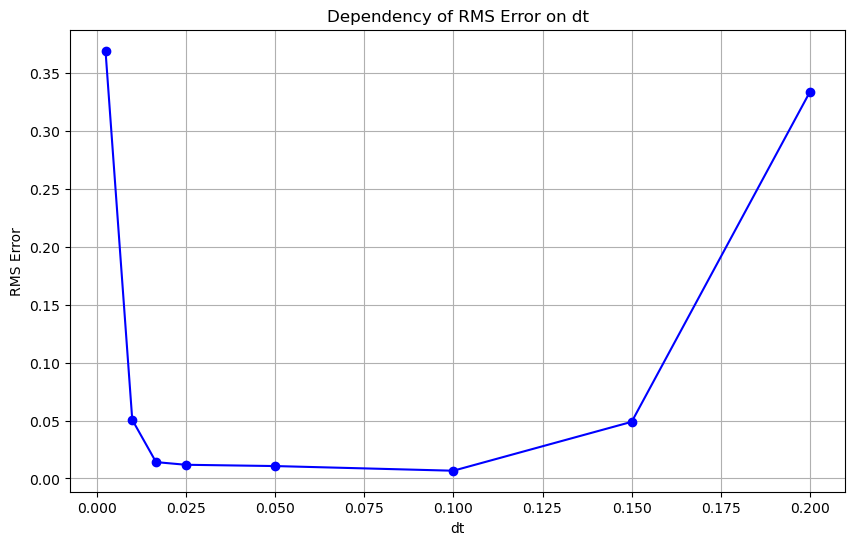

In [18]:
plot_rms_vs_dt(rms_errors_TRPO_circle)

## PID evaluation

In [20]:
import numpy as np

def follow_trajectory_pid(trajectory, robot_model, Kp, Kd, Ki, dt=0.1, max_steps=100, tolerance=0.01):
    """
    Function to follow a trajectory using a PID controller for a robot described by X_dot = AX + BU + G.
    
    Parameters:
    trajectory: Array of target points (shape: n x 3)
    Kp, Kd, Ki: Proportional, Derivative, Integral gains
    dt: Time step for simulation
    
    Returns:
    states: Array of robot states throughout the simulation
    errors: Array of position errors throughout the simulation
    """
    A = np.zeros((6,6))
    A[0,3] = 1
    A[1,4] = 1
    A[2,5] = 1
    G = np.array([0,0,0,0,0,-g]).reshape((6,1))
    
    Kp_matrix = Kp * robot_model.jacobian()
    Kd_matrix = Kd * robot_model.jacobian()
    Ki_matrix = Ki * robot_model.jacobian()
    
    # Initialize state (position and velocity)
    X = np.zeros((6,1))
    X[:3] = trajectory[0].reshape((3,1))  # Start at the first point of trajectory
    
    # Initialize lists to store states and errors
    states = [X]
    errors = []
    
    # Initialize integral error
    integral_error = np.zeros(3)
    
    # Initialize previous error for derivative term
    prev_error = np.zeros(3)
    
    # Loop through each trajectory point
    for target in trajectory:
        point_reached = False
        step_count = 0
        
        while not point_reached and step_count < max_steps:
            Kp_matrix = Kp * robot_model.jacobian()
            Kd_matrix = Kd * robot_model.jacobian()
            Ki_matrix = Ki * robot_model.jacobian()
            
            # Get current state
            current_state = states[-1]
            
            # Calculate error
            error = target - current_state[:3].flatten()  # Assuming first 3 elements are position
            
            # Check if point is reached within tolerance
            if np.linalg.norm(error) < tolerance:
                point_reached = True
                continue
            
            # Calculate integral error
            integral_error += error * robot_model.dt
            
            # Calculate derivative error
            derivative_error = (error - prev_error) / robot_model.dt
            
            # Calculate control input using PID
            u = Kp_matrix @ -error + Ki_matrix @ -integral_error + Kd_matrix @ -derivative_error# + robot_model.jacobian()@np.array([0,0,g])
            
            # Update robot state using the state-space model
            x_dot = A @ current_state + robot_model.B() @ u.reshape((4,1)) + G
            new_state = current_state + x_dot * robot_model.dt
            robot_model.pos = new_state[:3].flatten()
            
            # Store new state and error
            states.append(new_state)
            errors.append(error)
            
            # Update previous error
            prev_error = error
            
            step_count += 1
    
    return np.array(states), np.array(errors)

def simulate(des_state, r_model, Kp, Kd, Ki, end_t):
        point = des_state[:3]
        vel = des_state[3:]
        positions = []
        velocities = []
        
        A = np.zeros((6,6))
        A[0,3] = 1
        A[1,4] = 1
        A[2,5] = 1
        G = np.array([0,0,0,0,0,-g]).reshape((6,1))
        
        X = np.hstack((r_model.pos, r_model.v)).reshape((6,1)) 
        t = np.linspace(0, end_t, int(end_t/r_model.dt))
        
        Kp_matrix = Kp * r_model.jacobian()
        Kd_matrix = Kd * r_model.jacobian()
        Ki_matrix = Ki * r_model.jacobian()
        
        # Initialize errors
        integral_error = np.zeros(3)
        prev_error = np.zeros(3)
        max_integral = 10.0  # Anti-windup limit
        # integral_errors = []

        # Simulation loop
        for time in t:
             # Get current state
            current_state = X
            
            # Calculate error
            error = point - r_model.pos  # Assuming first 3 elements are position
            
            # Calculate integral error + anti-wundup
            integral_error += error * r_model.dt
            # integral_error = np.clip(integral_error, -max_integral, max_integral)
            # integral_errors.append(integral_error[2])
            
            # Calculate derivative error
            derivative_error = (error - prev_error) / r_model.dt
            
            u = Kp_matrix @ -error + Ki_matrix @ -integral_error + Kd_matrix @ -derivative_error# + r_model.jacobian()@np.array([0,0,g])
            
            # Update robot state using the state-space model
            x_dot = A @ current_state + r_model.B() @ u.reshape((4,1)) + G
            X = current_state + x_dot * r_model.dt
            r_model.pos = X[:3].flatten()
            
            # Store results
            positions.append(X[:3].flatten())
            velocities.append(X[3:].flatten())
            
            prev_error = error
        # print(f'max int err: {max(integral_errors)}')
        return positions, velocities
    
def rms_errors_different_dt_pid(robot_model, trajectory, Kp, Kd, Ki, dt_arr):
    rms_errors_dict = {}
    
    for dt in dt_arr:
        # initialization
        robot_model.dt = dt
        robot_model.cur_state = np.hstack((trajectory[0], 
                                   np.zeros(3),
                                   trajectory[1]))
        
        states, error = follow_trajectory_pid(trajectory, robot_model, Kp, Kd, Ki, robot_model.dt)

        
        mean_err = np.mean(error**2)
        rms_errors_dict[dt] = np.sqrt(mean_err)
    
    return rms_errors_dict.copy()

In [21]:
simple_robot_model = CDPR4(pos=np.array([0,0,1]))
simple_robot_model.v = np.array([0,0,0])

circle_trajectory = horizontal_circle_trajectory_points(t_span = np.linspace(0, 10, 20)) 

Kp, Kd, Ki = 12, 6.5, 10
rms_errors_pid_circle = rms_errors_different_dt_pid(simple_robot_model,
                                            circle_trajectory,
                                            Kp, Kd, Ki,
                                            dt_arr)

In [23]:
rms_errors_pid_circle

{0.2: inf,
 0.15: inf,
 0.1: inf,
 0.05: 0.045105211306175584,
 0.025: 0.047577962261186,
 0.016666666666666666: 0.048858339775120455,
 0.01: 0.05717512397644541,
 0.0025: 0.08041380257343156}

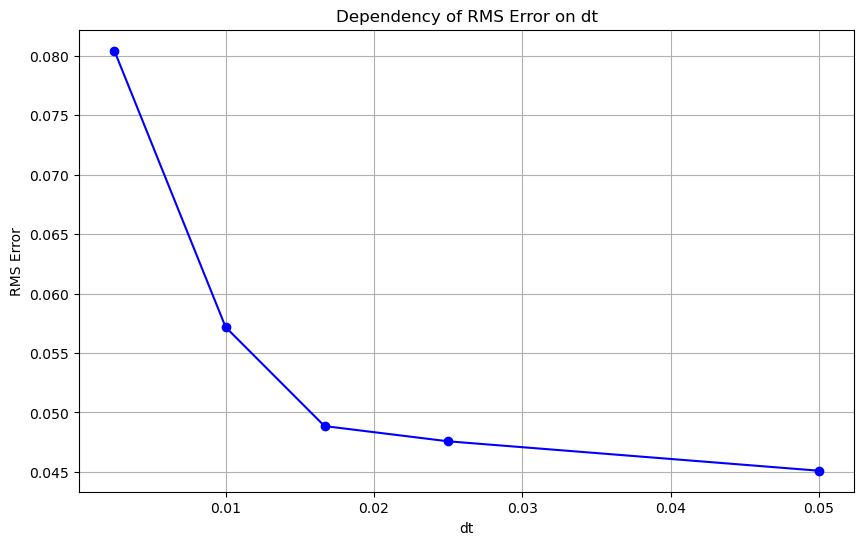

In [22]:
plot_rms_vs_dt(rms_errors_pid_circle)